In [1]:
%%capture
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.svm import SVC
!pip install openpyxl
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [3]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.merge(max_calculated,how='inner',
                                 left_index=True,right_index=True)
whole_data = whole_data.drop(['PU_label','year'],axis=1)
M_elements = pd.get_dummies(whole_data['M'],prefix='M',dtype=float)
A_elements = pd.get_dummies(whole_data['A'],prefix='A',dtype=float)
X_elements = pd.get_dummies(whole_data['X'],prefix='X',dtype=float)
whole_data = whole_data.drop(['M','A','X'],axis=1)
groups = pd.get_dummies(whole_data['X_X_group'],prefix='group',dtype=float)
whole_data = whole_data.drop(['X_X_group'],axis=1)
whole_data = pd.concat([whole_data,M_elements,A_elements,X_elements,groups],axis=1)


### I. KMeans on the 'simple' elemental

In [6]:
list_of_inertia = np.zeros(10)
for i in range(1,11):
    inertia = KMeans(n_clusters=i,random_state=17866817).fit(max_elemental.drop(['class'],axis=1))
    list_of_inertia[i-1] = inertia.inertia_

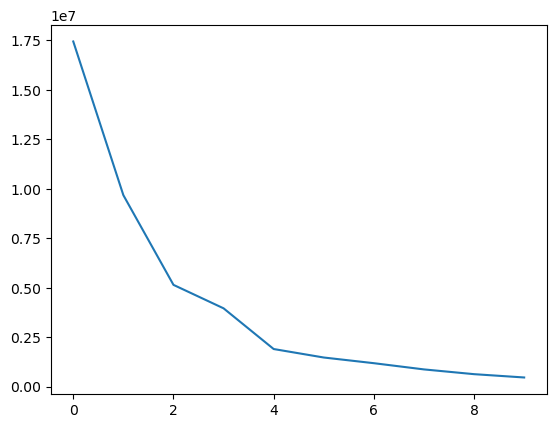

In [7]:
plt.plot(list_of_inertia)

In [8]:
clusterized_data = KMeans(n_clusters=4,random_state=17866817).fit(max_elemental.drop(['class'],axis=1))
kmeans_base_df = max_elemental.copy()
kmeans_base_df['cluster'] = clusterized_data.labels_

In [9]:
kmeans_base_df.groupby('cluster').sum()

,M_M_atomic_number,M_M_atomic_mass,M_M_molar_volume,M_M_density,M_M_atomic_radius,M_M_atomic_radius_calculated,M_M_van_der_waals_radius,M_M_average_ionic_radius,M_M_average_cationic_radius,M_M_average_anionic_radius,...,X_X_average_cationic_radius,X_X_average_anionic_radius,X_X_electron_affinity,X_X_electronegativity,X_X_first_ionization_energy,X_X_second_ionization_energy,X_X_valence_electrons,X_X_row,X_X_group,class
cluster,,,,,,,,,,,,,,,,,,,,,
0,21734,48543.739426,7040,4854.373943,1037.2,1281.10,1505.30,590.106333,590.106333,0.0,...,205.920,464.64,419.623991,1967.68,9079.635136,19002.510208,1760,1408,10208,12.0
1,14642,32691.030202,4760,3269.103020,701.6,865.68,1017.56,399.276000,399.276000,0.0,...,139.230,314.16,283.723040,1330.42,6139.071484,12848.288152,1190,952,6902,1.0
2,44402,110263.554800,6040,11026.355480,860.3,1192.86,1328.64,475.767667,475.767667,0.0,...,176.670,398.64,360.018311,1688.18,7789.914236,16303.290008,1510,1208,8758,2.0
3,14730,32893.170202,4780,3289.317020,704.2,869.24,1021.82,400.598000,400.598000,0.0,...,139.815,315.48,284.915153,1336.01,6164.865902,12902.272556,1195,956,6931,0.0


In [ ]:
#almost all the positives in the same cluster

### II. KMeans on preprocessed elemental data like in the article

In [12]:
tree_elem = DecisionTreeClassifier(random_state=17866817).fit(X=max_elemental.drop(['class'],axis=1),
                                                                y=max_elemental['class'])
imp_feat_elem = tree_elem.feature_importances_
feat_names_elem = tree_elem.feature_names_in_

In [15]:
imp_feat_elem = imp_feat_elem.reshape(-1,1)
feat_names_elem = feat_names_elem.reshape(-1,1)

In [19]:
feat_elem_df = np.hstack((imp_feat_elem,feat_names_elem))
feat_elem_df = pd.DataFrame(feat_elem_df)
feat_elem_df.columns = ['features','names']
feat_elem_df = feat_elem_df.set_index('names',drop=True)
feat_elem_df = feat_elem_df[feat_elem_df['features']>0]

In [20]:
df_tree = max_elemental.copy()
df_tree = df_tree.filter(items=list(feat_elem_df.index),axis=1)

In [22]:
df_tree['class'] = max_elemental['class'].copy()

In [24]:
inertia_tree = np.zeros(10)
for i in range(1,11):
    interm = KMeans(n_clusters = i, random_state = 17866817).fit(X=df_tree.drop(['class'],axis=1))
    inertia_tree[i-1] = interm.inertia_

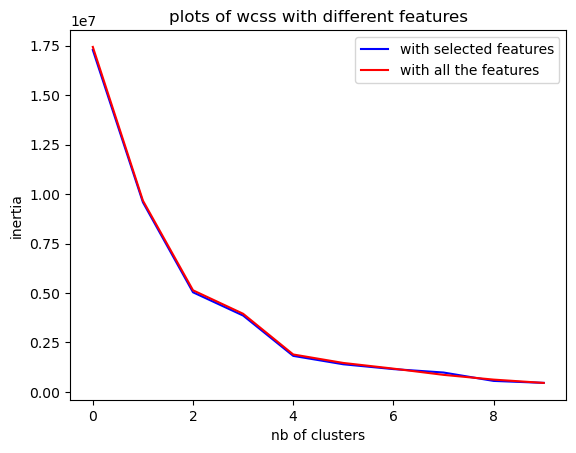

In [32]:
plt.plot(inertia_tree,'b-',label='with selected features')
plt.plot(list_of_inertia,'r-',label='with all the features')
plt.title('plots of wcss with different features')
plt.xlabel('nb of clusters')
plt.ylabel('inertia')
plt.legend()

In [34]:
#very much similar

In [33]:
tree_cl = KMeans(n_clusters = 4, random_state = 17866817).fit(X=df_tree.drop(['class'],axis=1))
df_tree['cluster'] = tree_cl.labels_

In [35]:
df_tree.groupby('cluster').sum()

,M_M_atomic_number,M_M_atomic_mass,M_M_density,M_M_average_cationic_radius,M_M_electronegativity,M_M_first_ionization_energy,M_M_group,A_A_atomic_number,A_A_atomic_mass,A_A_average_cationic_radius,A_A_electron_affinity,A_A_second_ionization_energy,X_X_atomic_number,X_X_atomic_radius,X_X_electron_affinity,X_X_first_ionization_energy,class
cluster,,,,,,,,,,,,,,,,,
0,21734,48543.739426,4854.373943,590.106333,1134.68,4863.441567,3662,17544,38488.380827,480.150000,629.203658,13364.312236,4576,475.20,419.623991,9079.635136,12.0
1,14642,32691.030202,3269.103020,399.276000,765.68,3289.076039,2474,23136,54479.727400,434.340833,397.046286,8579.195966,3094,321.30,283.723040,6139.071484,1.0
2,44402,110263.554800,11026.355480,475.767667,1079.80,4567.035860,3330,28458,68018.252531,509.049833,537.868557,11100.330564,3926,407.70,360.018311,7789.914236,2.0
3,14730,32893.170202,3289.317020,400.598000,770.08,3303.797039,2490,38042,95417.732678,487.731000,465.067577,8593.588098,3107,322.65,284.915153,6164.865902,0.0


In [36]:
#probably exactly the same clusters

### III. With the whole data

In [38]:
inertia_whole = np.zeros(10)
for i in range(1,11):
    interm = KMeans(n_clusters=i,random_state=17866817).fit(X=whole_data.drop(['class'],axis=1))
    inertia_whole[i-1] = interm.inertia_

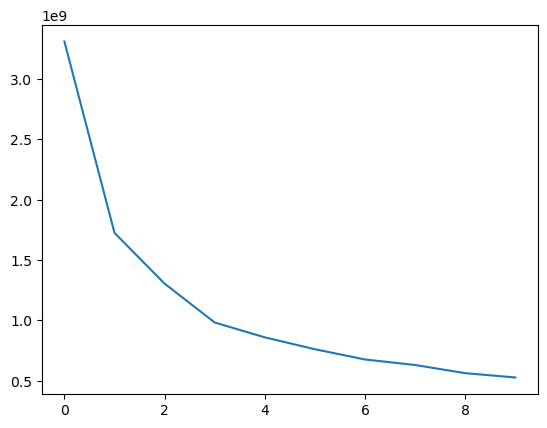

In [40]:
plt.plot(inertia_whole)

In [41]:
#the shape changes (and obviously not the same scale because many more features)

In [42]:
data_whole_wo_pp = whole_data.copy()
cl_whole = KMeans(n_clusters=4,random_state=17866817).fit(X=whole_data.drop(['class'],axis=1))
data_whole_wo_pp['cluster'] = cl_whole.labels_

In [43]:
data_whole_wo_pp.groupby('cluster').sum()['class']

cluster
0     5.0
1     0.0
2    10.0
3     0.0
Name: class, dtype: float64

In [44]:
#binary whereas for the other method, ther was another cluster with positive instances

### IV. With whole data but selected features by decision tree

In [46]:
tree_whole = DecisionTreeClassifier(random_state=17866817).fit(X=whole_data.drop(['class'],axis=1),
                                                               y=whole_data['class'])
imp_feat_whole = tree_whole.feature_importances_
names_feat_whole = tree_whole.feature_names_in_
imp_feat_whole = imp_feat_whole.reshape(-1,1)
names_feat_whole = names_feat_whole.reshape(-1,1)
whole_feat_df = np.hstack((imp_feat_whole,names_feat_whole))
whole_feat_df = pd.DataFrame(whole_feat_df)
whole_feat_df.columns = ['features','names']
whole_feat_df = whole_feat_df.set_index('names',drop=True)

In [48]:
whole_feat_df = whole_feat_df[whole_feat_df['features']>0]

In [50]:
df_selected = whole_data.filter(items=list(whole_feat_df.index),axis=1)

In [52]:
list_inertia_pp = np.zeros(10)
for i in range(1,11):
    interm = KMeans(n_clusters=i,random_state=17866817).fit(X=df_selected)
    list_inertia_pp[i-1] = interm.inertia_

In [54]:
cl_pp = KMeans(n_clusters=4,random_state=17866817).fit(df_selected)
df_selected['cluster'] = cl_pp.labels_
df_selected['class'] = whole_data['class'].copy()

In [55]:
df_selected.groupby('cluster').sum()

,M_M_atomic_radius,M_M_van_der_waals_radius,A_A_atomic_number,A_A_second_ionization_energy,dMM,dMA,rMX,rMA,dEc,density,dEf,dH,M_Ti,M_V,A_Zn,class
cluster,,,,,,,,,,,,,,,,
0,879.40,1313.25,27928,10962.028551,1502.72011,1293.89584,1332.89683,1701.39364,4.302211e+06,6529.974830,-397418.548918,70533.785932,56.0,17.0,13.0,9.0
1,821.35,1206.36,27958,10710.233701,1234.74235,1260.66389,1204.12906,1636.21402,2.778390e+06,4693.969232,12180.672430,146474.549778,0.0,19.0,34.0,0.0
2,954.55,1355.71,29530,11557.799053,1530.18949,1405.72298,1396.57246,1830.72795,3.758126e+06,4287.929803,-557558.048141,61893.759619,104.0,113.0,27.0,6.0
3,648.00,998.00,21764,8407.365559,1070.26617,1000.98252,994.38020,1305.36315,2.796059e+06,5325.002808,119398.301831,205643.740256,0.0,11.0,10.0,0.0


In [56]:
whole_feat_df.sort_values('features',ascending=False)

,features
names,
dH,0.227331
dEc,0.115723
rMX,0.112107
dEf,0.089482
A_A_atomic_number,0.07399
dMA,0.063235
M_M_van_der_waals_radius,0.058723
rMA,0.055926
dMM,0.053689
